In [1]:
import pandas as pd
from pandas import read_csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

os.chdir('/Users/xiaodanxu/Library/CloudStorage/GoogleDrive-arielinseu@gmail.com/My Drive/BEAM-CORE/BEAM Validation')

plt.style.use('ggplot')

In [2]:
# load parameter and data for validation
meter_to_mile = 0.000621371
percent_of_samples = 0.25
mps_to_mph = 2.23694
scenario_name = 'AUS2018'
modeled_vmt = read_csv('sample output/AUS2018/0.linkstats.csv.gz', low_memory=False)
observed_vmt = read_csv('data for validation/Austin/VMT/austin_hpms_inventory.csv', low_memory=False)
model_network = read_csv('sample output/AUS2018/beam_network_by_county.csv', low_memory=False)

modeled_vmt_by_hour = modeled_vmt.groupby('hour')[['volume']].sum()
modeled_vmt.head(5)
print(modeled_vmt_by_hour)

         volume
hour           
0.0         0.0
1.0         0.0
2.0         0.0
3.0         0.0
4.0      7711.0
5.0   1075332.0
6.0   2832623.0
7.0   4593517.0
8.0   5437580.0
9.0   4459511.0
10.0  3703920.0
11.0  3782627.0
12.0  3812116.0
13.0  4046531.0
14.0  3963737.0
15.0  4093363.0
16.0  4582452.0
17.0  5605532.0
18.0  6067513.0
19.0  4925440.0
20.0  3508100.0
21.0  3168047.0
22.0  2270827.0
23.0  1606663.0
24.0   865691.0
25.0   281617.0
26.0   159267.0
27.0   107665.0
28.0    65521.0
29.0    45473.0
30.0    35176.0
31.0    26999.0
32.0    18680.0
33.0    16813.0
34.0    12691.0
35.0     8622.0
36.0     6691.0
37.0     4094.0
38.0     4391.0
39.0     2171.0
40.0     1278.0
41.0      918.0
42.0      578.0
43.0      499.0
44.0      495.0
45.0      236.0
46.0      412.0
47.0      131.0
48.0      157.0
49.0      447.0
50.0      290.0
51.0      198.0
52.0        5.0
53.0        0.0
54.0        0.0
55.0        0.0
56.0        2.0
57.0        0.0
58.0        0.0
59.0        0.0


In [4]:
print(observed_vmt.columns)
observed_vmt.loc[:, 'LN_MILES'] = meter_to_mile * observed_vmt.loc[:, 'Through_La'] * observed_vmt.loc[:, 'length']
total_lane_mile_observed = observed_vmt['LN_MILES'].sum()
print(total_lane_mile_observed)
observed_vmt.head(5)

Index(['Unnamed: 0', 'County_Cod', 'Route_ID', 'Begin_Poin', 'End_Point',
       'Route_Numb', 'F_System', 'Urban_Code', 'Through_La', 'Speed_Limi',
       'AADT', 'AADT_Singl', 'AADT_Combi', 'Shape_Leng', 'name', 'length'],
      dtype='object')
9852.851179032255


,Unnamed: 0,County_Cod,Route_ID,Begin_Poin,End_Point,Route_Numb,F_System,Urban_Code,Through_La,Speed_Limi,AADT,AADT_Singl,AADT_Combi,Shape_Leng,name,length,LN_MILES
0,1,21,SH0071-KG,155.732,155.832,71,3,99998,4,75,18981,645,1329,0.001657,Bastrop,161.101188,0.400414
1,2,21,011AA0127,0.000,0.444,0,5,99999,2,0,110,0,0,0.007191,Bastrop,715.557002,0.889253
2,3,21,SH0021-KG,38.622,38.707,21,2,99998,4,65,43843,1666,2368,0.001415,Bastrop,136.130091,0.338349
3,4,21,SL0109-KG,1.781,2.083,0,5,99998,2,0,3236,0,0,0.004597,Bastrop,487.932775,0.606375
4,5,21,SH0021-KG,37.307,37.407,21,3,99999,4,65,46646,1726,2426,0.001673,Bastrop,160.934412,0.400000


In [5]:
model_network = model_network.drop_duplicates(subset=['linkId'])
model_network.head(5)
model_network.loc[:, 'lane_mile'] = meter_to_mile * model_network.loc[:, 'linkLength'] * model_network.loc[:, 'numberOfLanes']
total_lane_mile_modeled = model_network['lane_mile'].sum()
print(total_lane_mile_modeled)

46312.51890791604


In [6]:
# filter modeled network
model_vmt_24_hour = modeled_vmt.loc[(modeled_vmt['hour'] <= 28) & (modeled_vmt['hour'] >= 5)]
model_vmt_24_hour.loc[model_vmt_24_hour['hour']>=24, 'hour'] -= 24
model_network.loc[:, 'fromNodeId'] = model_network.loc[:, 'fromNodeId'].astype(int)
model_network.loc[:, 'toNodeId'] = model_network.loc[:, 'toNodeId'].astype(int)
model_vmt_24_hour = pd.merge(model_vmt_24_hour, model_network, 
                                 left_on = ['link', 'from', 'to'],
                                 right_on = ['linkId', 'fromNodeId', 'toNodeId'], how = 'left')
model_vmt_24_hour.head(5)

,link,from,to,hour,length_x,freespeed,capacity,stat,volume,traveltime,...,numberOfLanes,linkModes,attributeOrigId,attributeOrigType,fromNodeId,toNodeId,name,txdot_abbr,fips_code,lane_mile
0,285550,102109,120927,5.0,13.623,14.75232,2100.0,AVG,4.0,0.923448,...,1.0,car;walk;bike,544896591.0,tertiary,102109.0,120927.0,Williamson,14.0,491.0,0.008465
1,285550,102109,120927,6.0,13.623,14.75232,2100.0,AVG,22.0,0.926878,...,1.0,car;walk;bike,544896591.0,tertiary,102109.0,120927.0,Williamson,14.0,491.0,0.008465
2,285550,102109,120927,7.0,13.623,14.75232,2100.0,AVG,31.0,0.932596,...,1.0,car;walk;bike,544896591.0,tertiary,102109.0,120927.0,Williamson,14.0,491.0,0.008465
3,285550,102109,120927,8.0,13.623,14.75232,2100.0,AVG,41.0,0.959899,...,1.0,car;walk;bike,544896591.0,tertiary,102109.0,120927.0,Williamson,14.0,491.0,0.008465
4,285550,102109,120927,9.0,13.623,14.75232,2100.0,AVG,36.0,0.947734,...,1.0,car;walk;bike,544896591.0,tertiary,102109.0,120927.0,Williamson,14.0,491.0,0.008465


In [7]:
model_vmt_24_hour.loc[:, 'lane_mile'] = meter_to_mile * model_vmt_24_hour.loc[:, 'numberOfLanes'] * model_vmt_24_hour.loc[:, 'linkLength'] / 24.0
total_lane_mile_with_cars = model_vmt_24_hour.loc[:, 'lane_mile'].sum()
print(total_lane_mile_with_cars)

46312.518907916005


4.0


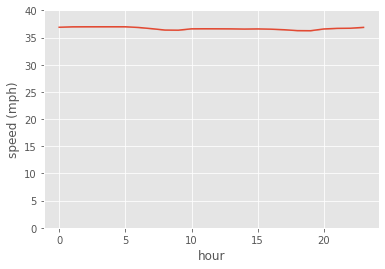

In [8]:

demand_scaling = 1/percent_of_samples
print(demand_scaling)
model_vmt_24_hour.loc[:, 'VMT'] = demand_scaling * meter_to_mile * model_vmt_24_hour.loc[:, 'linkLength'] * model_vmt_24_hour.loc[:, 'volume']
# model_vmt_24_hour.loc[:, 'travel_time (hr)'] = model_vmt_24_hour.loc[:, 'linkLength'] /3600

model_vmt_24_hour.loc[:, 'speed'] = model_vmt_24_hour.loc[:, 'linkLength'] / model_vmt_24_hour.loc[:, 'traveltime'] 
model_vmt_24_hour.loc[:, 'speed (mph)'] = mps_to_mph * model_vmt_24_hour.loc[:, 'speed']
model_vmt_24_hour.loc[:, 'volume'] *= demand_scaling
sns.lineplot(x = 'hour', y = 'speed (mph)', data = model_vmt_24_hour, ci = 95)
plt.ylim([0, 40])
plt.savefig('plot/' + scenario_name + '/modeled_speed_for_all_links.png', dpi = 200)
plt.show()


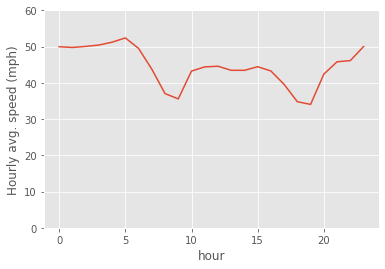

In [9]:
# SUMMARIZE HOURLY SPEED
model_vmt_24_hour.loc[:, 'VMT'] =  meter_to_mile * model_vmt_24_hour.loc[:, 'linkLength'] * model_vmt_24_hour.loc[:, 'volume']
model_vmt_24_hour.loc[:, 'VHT'] =  model_vmt_24_hour.loc[:, 'traveltime'] * model_vmt_24_hour.loc[:, 'volume'] / 3600.0
model_avg_speed = model_vmt_24_hour.groupby('hour')[['VMT','VHT']].sum()
model_avg_speed = model_avg_speed.reset_index()
model_avg_speed.loc[:, 'speed'] = model_avg_speed.loc[:, 'VMT'] / model_avg_speed.loc[:, 'VHT']
model_avg_speed.to_csv('sample output/SFB2021/avg_speed_whole_network.csv', sep = ',', index = False)
sns.lineplot(x = 'hour', y = 'speed', data = model_avg_speed, ci = None)
plt.ylim([0, 60])
plt.ylabel('Hourly avg. speed (mph)')
plt.savefig('plot/' + scenario_name + '/avg_speed_for_all_links.png', dpi = 200)
plt.show()

In [10]:
# create 24 pivot table for speed and volume
speed_by_hour = pd.pivot_table(model_vmt_24_hour, values='speed (mph)', 
                               index=['linkId', 'fromNodeId', 'toNodeId'],
                    columns=['hour'])
speed_by_hour.columns = ['speed_' + str(i+1) for i in range(24)]
speed_by_hour = speed_by_hour.reset_index()
# print(speed_by_hour.head(5))

volume_by_hour = pd.pivot_table(model_vmt_24_hour, values='volume', 
                               index=['linkId', 'fromNodeId', 'toNodeId'],
                    columns=['hour'])
volume_by_hour.columns = ['volume_' + str(i+1) for i in range(24)]
volume_by_hour = volume_by_hour.reset_index()

combined_metric_by_hour = pd.merge(speed_by_hour, volume_by_hour, 
                                   on = ['linkId', 'fromNodeId', 'toNodeId'],
                                    how = 'outer')
combined_metric_by_hour.head(5)
combined_metric_by_hour.to_csv('sample output/AUS2018/processed_linkstats.csv', 
                               sep = ',', index = False)

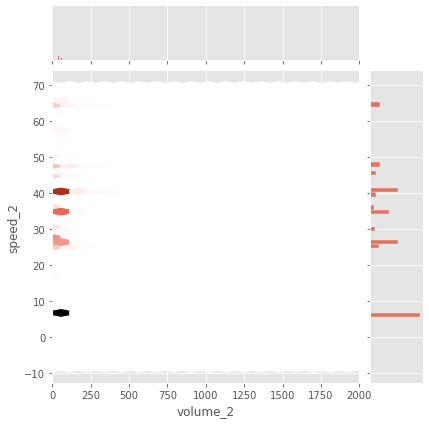

In [11]:
sns.jointplot(x = 'volume_2', y = 'speed_2', kind="hex", data = combined_metric_by_hour)
plt.xlim([0,2000])
plt.show()

In [11]:
observed_vmt.loc[:, 'DVMT'] = meter_to_mile * observed_vmt.loc[:, 'AADT'] * observed_vmt.loc[:, 'length']
observed_vmt.loc[:, 'DTRKVMT'] = meter_to_mile * (observed_vmt.loc[:, 'AADT_Singl']  + observed_vmt.loc[:, 'AADT_Combi']) * observed_vmt.loc[:, 'length']
observed_vmt.loc[:, 'PVMT'] = observed_vmt.loc[:, 'DVMT'] - observed_vmt.loc[:, 'DTRKVMT']

print(observed_vmt[['DVMT', 'DTRKVMT', 'PVMT']].sum())

DVMT       4.948849e+07
DTRKVMT    3.019201e+06
PVMT       4.646929e+07
dtype: float64


In [12]:
# assign roadway classification to modeled network, 
# ref: https://wiki.openstreetmap.org/wiki/User:UltimateRiff/HFCS
modeled_roadtype = model_vmt_24_hour.attributeOrigType.unique()
modeled_roadtype_lookup = {'tertiary': 'Minor collector',
                           'trunk_link': 'Freeway and major arterial',
                           'residential': 'Local',
                           'track': 'Local',
                           'footway': 'Local',
                           'motorway': 'Freeway and major arterial',
                           'secondary': 'Major collector',
                           'unclassified': 'Local',
                           'path': 'Local',
                           'secondary_link': 'Major collector',
                           'primary': 'Minor arterial',
                           'motorway_link': 'Freeway and major arterial',
                           'primary_link': 'Minor arterial',
                           'trunk': 'Freeway and major arterial',
                           'pedestrian': 'Local',
                           'tertiary_link': 'Minor collector',
                           'cycleway': 'Local',
                           np.nan: 'Local',
                           'steps': 'Local',
                           'living_street': 'Local', 
                           'bus_stop': 'Local',
                           'corridor': 'Local', 
                           'road': 'Local',
                           'bridleway': 'Local'}

observed_roadtype_lookup = {1: 'Freeway and major arterial',
                            2: 'Freeway and major arterial',
                            3: 'Freeway and major arterial',
                            4: 'Minor arterial',
                            5: 'Major collector',
                            6: 'Minor collector',
                            7: 'Local'}
model_vmt_24_hour.loc[:, 'road_class'] = model_vmt_24_hour.loc[:, 'attributeOrigType'].map(modeled_roadtype_lookup)
observed_vmt.loc[:, 'road_class'] = observed_vmt.loc[:, 'F_System'].map(observed_roadtype_lookup)
# print(modeled_roadtype)

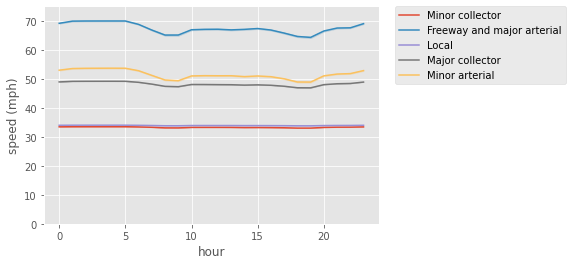

In [13]:
sns.lineplot(x = 'hour', y = 'speed (mph)', hue = 'road_class',
             data = model_vmt_24_hour, ci = 98)
plt.ylim([0, 75])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('plot/' + scenario_name + '/modeled_speed_by_roadtype.png', dpi = 200, bbox_inches= 'tight')
plt.show()

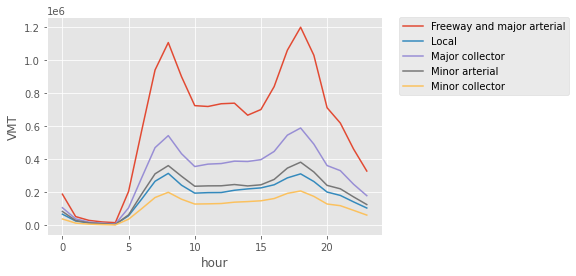

In [14]:
model_vmt_by_hour_roadtype = model_vmt_24_hour.groupby(['hour', 'road_class'])[['VMT']].sum()
model_vmt_by_hour_roadtype = model_vmt_by_hour_roadtype.reset_index()
sns.lineplot(x = 'hour', y = 'VMT', hue = 'road_class',
             data = model_vmt_by_hour_roadtype, ci = None)
# plt.ylim([0, 75])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('plot/' + scenario_name + '/modeled_VMT_by_hour_roadtype.png', dpi = 200, bbox_inches= 'tight')
plt.show()

Williamson


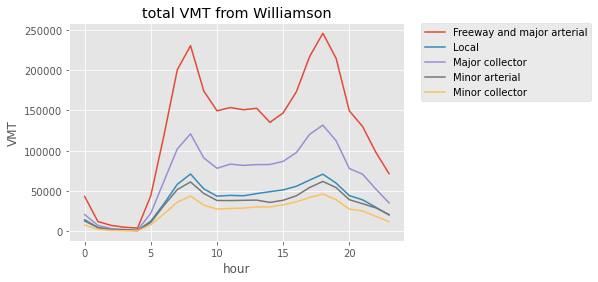

Bastrop


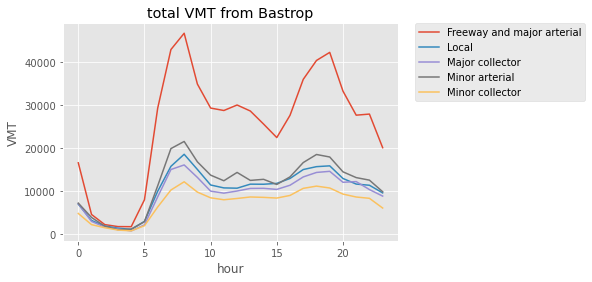

Hays


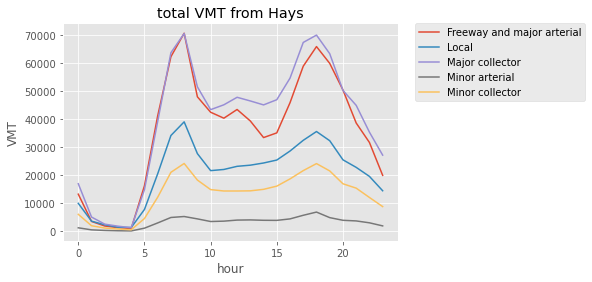

Travis


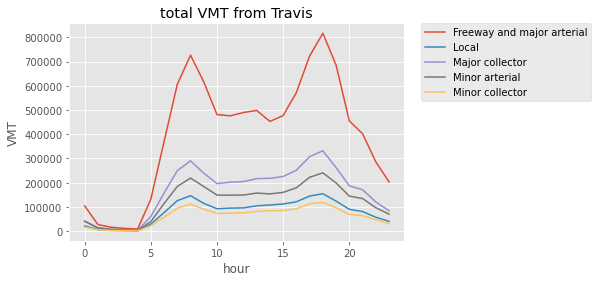

Caldwell


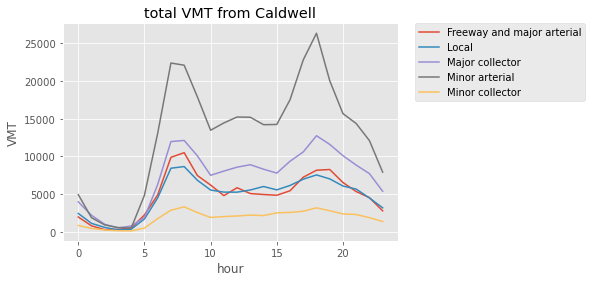

Burnet


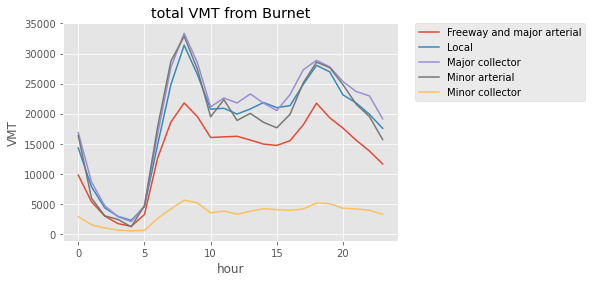

nan


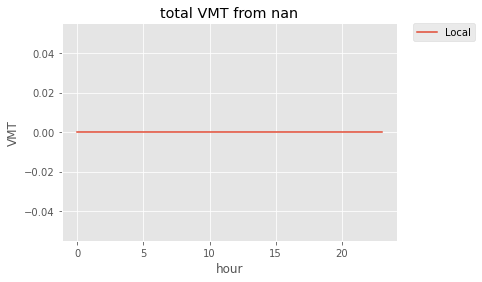

In [16]:
model_vmt_24_hour['name'] = model_vmt_24_hour['name'].astype(str)
model_vmt_24_hour = model_vmt_24_hour.loc[model_vmt_24_hour['name'] != '']
list_of_counties = model_vmt_24_hour.name.unique()
for county in list_of_counties:
    print(county)
#     if county == '':
#         continue
    model_vmt_by_county = model_vmt_24_hour.loc[model_vmt_24_hour['name'] == county]
    model_vmt_by_hour_county = model_vmt_by_county.groupby(['hour', 'road_class'])[['VMT']].sum()
    model_vmt_by_hour_county = model_vmt_by_hour_county.reset_index()
    sns.lineplot(x = 'hour', y = 'VMT', hue = 'road_class',
                 data = model_vmt_by_hour_county, ci = None)
    # plt.ylim([0, 75])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('total VMT from ' + county)
    plt.savefig('plot/' + scenario_name + '/modeled_VMT_by_hour_' + county + '.png', dpi = 200, bbox_inches= 'tight')
    plt.show()

In [17]:
model_vmt_24_hour_nolocal = model_vmt_24_hour.loc[model_vmt_24_hour['road_class'] != 'Local']
model_vmt_by_county = model_vmt_24_hour_nolocal.groupby(['name'])[['VMT']].sum()
model_vmt_by_county = model_vmt_by_county.reset_index()
model_vmt_by_county

observed_vmt_by_county = observed_vmt.groupby('name')[['PVMT']].sum()
observed_vmt_by_county = observed_vmt_by_county.reset_index()
observed_vmt_by_county

,name,PVMT
0,Bastrop,2.174914e+06
1,Burnet,1.311675e+06
2,Caldwell,1.171388e+06
3,Hays,5.071146e+06
4,Travis,2.633145e+07
5,Williamson,1.040872e+07


modeled_VMT     2.972518e+07
observed_VMT    4.646929e+07
dtype: float64


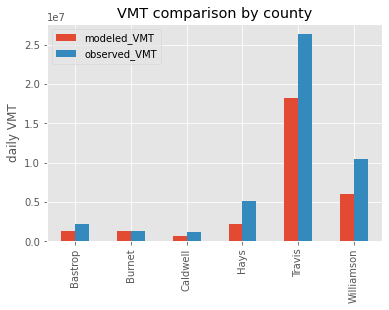

In [18]:
VMT_comparison = pd.merge(model_vmt_by_county, observed_vmt_by_county, 
                          on = 'name', how = 'left')
VMT_comparison = VMT_comparison.loc[:, ['name', 'VMT', 'PVMT']]
VMT_comparison.columns = ['county', 'modeled_VMT', 'observed_VMT']
VMT_comparison = VMT_comparison.loc[~VMT_comparison['county'].isin(['Santa Cruz', 'Yolo'])] 
print(VMT_comparison.loc[:, ['modeled_VMT', 'observed_VMT']].sum())

VMT_comparison.plot.bar(x = 'county')
plt.xlabel('')
plt.ylabel('daily VMT')
plt.title('VMT comparison by county')
plt.savefig('plot/' + scenario_name + '/VMT_comparison_by_county.png', dpi = 200, bbox_inches = 'tight')
plt.show()

In [19]:
model_vmt_by_roadtype = model_vmt_24_hour.groupby(['road_class'])[['VMT']].sum()
model_vmt_by_roadtype = model_vmt_by_roadtype.reset_index()
observed_vmt_by_roadtype = observed_vmt.groupby(['road_class'])[['PVMT']].sum()
observed_vmt_by_roadtype = observed_vmt_by_roadtype.reset_index()
VMT_comparison_by_roadtype = pd.merge(model_vmt_by_roadtype, observed_vmt_by_roadtype, 
                          on = 'road_class', how = 'left')
# VMT_comparison = VMT_comparison.loc[:, ['name', 'VMT', 'PVMT']]
VMT_comparison_by_roadtype.columns = ['road_class', 'modeled_VMT', 'observed_VMT']
VMT_comparison_by_roadtype

,road_class,modeled_VMT,observed_VMT
0,Freeway and major arterial,1.457955e+07,2.981258e+07
1,Local,4.172782e+06,NaN
2,Major collector,7.510375e+06,9.902153e+06
3,Minor arterial,4.921738e+06,6.754557e+06
4,Minor collector,2.713523e+06,NaN


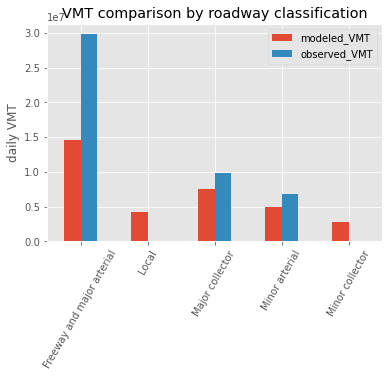

In [20]:
VMT_comparison_by_roadtype.plot.bar(x = 'road_class')
plt.xlabel('')
plt.ylabel('daily VMT')
plt.title('VMT comparison by roadway classification')
plt.xticks(rotation = 60)
plt.savefig('plot/' + scenario_name + '/VMT_comparison_by_roadway_type.png', dpi = 200, bbox_inches = 'tight')
plt.show()

/var/folders/w6/7qcyt43n21ddydhdfdslrp7c0000gp/T/ipykernel_42082/2897943063.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.0f}%'.format(x*100) for x in ax.get_yticks()])


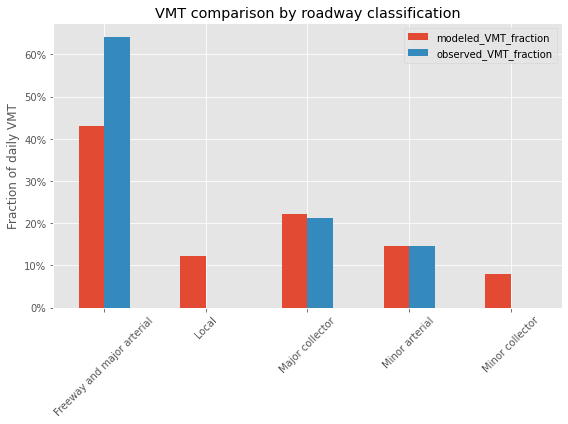

In [21]:
VMT_comparison_by_roadtype.loc[:, 'modeled_VMT_fraction'] = VMT_comparison_by_roadtype.loc[:, 'modeled_VMT'] / VMT_comparison_by_roadtype.loc[:, 'modeled_VMT'].sum()
VMT_comparison_by_roadtype.loc[:, 'observed_VMT_fraction'] = VMT_comparison_by_roadtype.loc[:, 'observed_VMT'] / VMT_comparison_by_roadtype.loc[:, 'observed_VMT'].sum()
percent_VMT_comparison_by_roadtype = VMT_comparison_by_roadtype.loc[:, ['road_class', 'modeled_VMT_fraction', 'observed_VMT_fraction']]

import matplotlib.ticker as mtick
# plt.figure(figsize = (12,8))
ax = percent_VMT_comparison_by_roadtype.plot.bar(x = 'road_class',figsize = (8,6))
# ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
plt.xlabel('')
plt.xticks(rotation = 45)
ax.set_yticklabels(['{:.0f}%'.format(x*100) for x in ax.get_yticks()]) 
# vals = ax.get_yticks()
# ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.ylabel('Fraction of daily VMT')
plt.title('VMT comparison by roadway classification')
plt.tight_layout()
plt.savefig('plot/' + scenario_name + '/percent_VMT_comparison_by_roadway_type.png', dpi = 200)
plt.show()

<AxesSubplot:xlabel='attributeOrigType'>

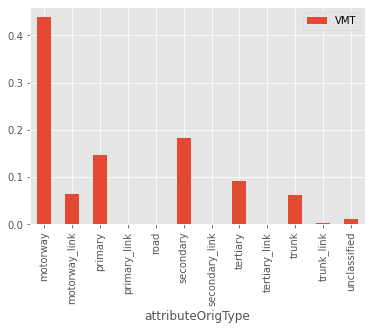

In [19]:
model_vmt_by_osmtype = model_vmt_24_hour.groupby(['attributeOrigType'])[['VMT']].sum()
model_vmt_by_osmtype.loc[:, 'VMT'] /= model_vmt_by_osmtype.loc[:, 'VMT'].sum()
model_vmt_by_osmtype.plot.bar()